In [1]:
%pylab inline 

import gym
from gym import error, spaces, utils
from gym.utils import seeding
from collections import Counter
import time
import progressbar as pb
from tqdm import tqdm
import os
import shutil

Populating the interactive namespace from numpy and matplotlib


In [2]:
from empyrical import sortino_ratio, calmar_ratio, omega_ratio

In [3]:
# load the market data
input_source = np.load(open('data_spy.npy','rb'))
to_predict = np.load(open('data_spy_targets.npy','rb'))

In [4]:
input_source.shape, to_predict.shape

((105, 54511), (4, 54511))

In [5]:
to_predict = to_predict[3,:].reshape(-1)

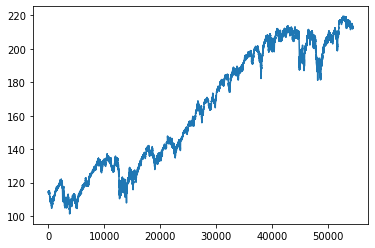

In [6]:
plot(to_predict);

In [7]:
input_source = input_source.T
input_source.shape

(54511, 105)

In [8]:
is_orig = np.copy(input_source)
cp = int(0.8*len(input_source))
test_input_source = input_source[cp:, :]
input_source = input_source[0:cp, :]

In [ ]:
input_source.shape, test_input_source.shape

In [ ]:
df=pd.DataFrame(input_source)

In [ ]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

In [ ]:
bars_per_episode = 1000
winlen = 1
traded_amt = 1000
commission = 0
slippage = 0.0

class TradingEnv(gym.Env):
    
    """ This gym implements a simple trading environment for reinforcement learning. """
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        self.action_space = spaces.Discrete( 2 )
        self.observation_space= spaces.Box( #np.min(input_source, axis=0), 
                                            #np.max(input_source, axis=0)
                                            np.ones((winlen*input_source.shape[1], ))*-999999, 
                                            np.ones((winlen*input_source.shape[1], ))*999999, 
                                          )
        self.reset()
        
    def _configure(self, display=None):
        self.display = display

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def _step(self, action):
        return self.step(action)
    
    def _reset(self):
        return self.reset()

    def step(self, action):
        
        #assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        
        if (self.idx < self.end_idx) and (self.balance > 0):
            self.idx += 1
            done = False
        else:
            done = True
        
        info = {}
        
        observation = input_source[self.idx - winlen : self.idx, :].reshape(-1)
        
        # execute the action and get the reward
        if action == 0 and self.position == 0: # buy 
            self.position = -1
            self.open_idx = self.idx
        if action == 1 and self.position == 0: # sell
            self.position = 1
            self.open_idx = self.idx
        if action == 2:# or ((self.position==0) and ((self.idx - self.open_idx) > 8)): # close
            self.position = 0
        if action == 3:
            pass
        
        
        comm_paid = 2 * commission; 
        slip_paid = 2 * slippage * traded_amt;
        
        ret = 0
        if self.position == -1: # long
            ret = (to_predict[self.idx] - to_predict[self.open_idx])*traded_amt - comm_paid - slip_paid
        elif self.position == 1: # short
            ret = (to_predict[self.open_idx] - to_predict[self.idx])*traded_amt - comm_paid - slip_paid

        if self.position == -1: # long
            self.balance += (to_predict[self.idx] - to_predict[self.open_idx])*traded_amt - comm_paid - slip_paid
            self.returns.append(self.balance)
        elif self.position == 1: # short
            self.balance += (to_predict[self.open_idx] - to_predict[self.idx])*traded_amt - comm_paid - slip_paid
            self.returns.append(self.balance)
        
        if len(self.returns) > 5:
            reward = sortino_ratio(np.diff(np.array(self.returns))[1:])
            #print(np.diff(np.array(self.returns[1:])))
            #print(reward)
            if isnan(reward) or isinf(reward):
                reward = 0
        else:
            reward = 0
        self.prev_balance = self.balance
        
        return observation, reward, done, info
    
    def reset(self):
        # reset and return first observation
        self.idx = np.random.randint(winlen, input_source.shape[0] - bars_per_episode)
        self.end_idx = self.idx + bars_per_episode
        self.position = 0
        self.open_idx = 0
        self.balance = 10000
        self.prev_balance = self.balance
        self.returns = []
        return input_source[self.idx - winlen : self.idx, :].reshape(-1)
    
    def _render(self, mode='human', close=False):
        #... TODO
        pass        

In [ ]:
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, VecEnv, VecEnvWrapper
from stable_baselines import A2C, PPO2
from stable_baselines.common.vec_env import DummyVecEnv

# multiprocess environment
#n_cpu = 16
#env = SubprocVecEnv([lambda: TradingEnv() for i in range(n_cpu)])
env = TradingEnv()
env = DummyVecEnv([lambda: env])

t = 0
[shutil.rmtree('/home/peter/tblog/'+x) for x in os.listdir('/home/peter/tblog/') if x]
model = A2C(MlpLstmPolicy, env, verbose=1, policy_kwargs = {'n_lstm': 16}, 
            tensorboard_log='/home/peter/tblog')
try:
    model.learn(total_timesteps=1_000_000)
    model.save("a2c_trading")
except KeyboardInterrupt:
    pass

In [ ]:
input_source = test_input_source 

In [ ]:
env = TradingEnv()
env = DummyVecEnv([lambda: env])

In [ ]:

# visualize the behavior for one random episode
bars_per_episode = 1000

nstate = model.initial_state  # get the initial state vector for the reccurent network
#dones = np.zeros(nstate.shape[0])  # set all environment to not done
nstate=None

observation = env.envs[0].reset()#env.reset()
done = False
navs = []
acts = []
for i in tqdm(range(bars_per_episode)):
    action, nstate = model.predict([observation], state=nstate)
    acts.append(action)
    observation, reward, done, info = env.envs[0].step(action)#env.step(action)
    if done:
        break
    navs.append(env.get_attr('balance')[0])


kl = []
t = 0
for n in np.diff(vstack(navs).reshape(-1)):
    t = t + n
    kl.append(t)
plot(kl);

In [ ]:
# calculate the likelihood of success for any given episode
try:
    l = 1000

    krl = []
    p = pb.ProgressBar(max_value=l)
    for i in range(l):
        p.update(i)
        observation = env.envs[0].reset()
        done = False
        navs = []
        for i in (range(bars_per_episode)):
            action, nstate = model.predict([observation], state=nstate)
            acts.append(action)
            observation, reward, done, info = env.envs[0].step(action)#env.step(action)
            navs.append(env.get_attr('balance')[0])
        krl.append(sum(navs))
    p.finish()
except KeyboardInterrupt:
    pass

In [ ]:
krl = array(krl)
print('Profit likelihood: %3.3f%%' % (100*(sum(krl > 0) / len(krl))))

In [ ]:
hist(krl);